In [0]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
import joblib
from torch.autograd import Variable

In [3]:
path = "./Datasets/STL10_data/"
# path = "E:/Datasets/STL10_data/"

device = 'cuda'
num_workers = 0
batch_size = 64

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.STL10(path, split='train', download=True, transform=transform)
test_data = datasets.STL10(path, split='test', download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
# classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

0it [00:00, ?it/s]

100%|█████████▉| 2638331904/2640397119 [02:06<00:00, 21923490.99it/s]

Extracting ./Datasets/STL10_data/stl10_binary.tar.gz to ./Datasets/STL10_data/


2640404480it [02:20, 21923490.99it/s]                                

Files already downloaded and verified


In [0]:
device='cuda'
class Architecture(nn.Module):

    def __init__(self):
        super(Architecture, self).__init__()
        
        self.b_1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1),
                                nn.BatchNorm2d(16),
                                nn.ReLU())
        
        self.b_2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, padding=1),
                                nn.BatchNorm2d(32),
                                nn.ReLU())
        
        self.b_3 = nn.Sequential(nn.Conv2d(32, 32, kernel_size=3, padding=1),
                                nn.BatchNorm2d(32),
                                nn.ReLU())
        
        self.b_4 = nn.Sequential(nn.Conv2d(32, 16, kernel_size=3, padding=1),
                                nn.BatchNorm2d(16),
                                nn.ReLU())
        
        self.b_5 = nn.Sequential(nn.Conv2d(16, 3, kernel_size=3, padding=1),
                                nn.BatchNorm2d(3),
                                nn.ReLU())
        
        self.pool = nn.MaxPool2d(2)

        self.fc_1 = nn.Linear(3 * 3 * 3, 256)
        self.fc_2 = nn.Linear(256, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.b_1(x))
        x = self.pool(self.b_2(x))
        x = self.pool(self.b_3(x))
        x = self.pool(self.b_4(x))
        x = self.pool(self.b_5(x))
        # print(x.shape)
        
        x = x.view(-1, 3 * 3 * 3)
        x = self.relu(self.fc_1(x))
        # x = self.relu(self.fc_2(x))
        x = self.fc_2(x)
        return x

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight.data)
    if(isinstance(m, nn.Linear)):
        torch.nn.init.kaiming_uniform_(m.weight.data)
        
model = Architecture()
model.apply(init_weights)

model.to(device)

CE = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.02)

In [5]:
train_loss_plt, valid_loss_plt = [], []
test_accuracy_plt = []
test_loss_plt = []
n_epochs = 150
for epoch in range(n_epochs):
    train_loss, test_loss = 0, 0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = CE(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    train_loss_plt.append(train_loss)

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = CE(output, target)

            test_loss += loss.item() * data.size(0)
            _, pred = torch.max(output, 1)
            correct = np.squeeze(pred.eq(target.data.view_as(pred)))
            for i in range(len(target)):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    test_loss = test_loss / len(test_loader.dataset)
    test_loss_plt.append(test_loss)
    
    test_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
    test_accuracy_plt.append(test_accuracy)

    print('Epoch:', (epoch + 1), '\tTrain Loss:', train_loss,' | Test Loss:', test_loss,' | Test Acc.:',test_accuracy)

Epoch: 1 	Train Loss: 1.8512603660583495  | Test Loss: 1.9625809955596925  | Test Acc.: 30.4
Epoch: 2 	Train Loss: 1.5173444234848021  | Test Loss: 1.5674140968322754  | Test Acc.: 39.625
Epoch: 3 	Train Loss: 1.4034012160301208  | Test Loss: 1.5394246425628662  | Test Acc.: 41.9125
Epoch: 4 	Train Loss: 1.3151131050109863  | Test Loss: 1.457367175102234  | Test Acc.: 45.3
Epoch: 5 	Train Loss: 1.235749112033844  | Test Loss: 1.4232377452850342  | Test Acc.: 46.475
Epoch: 6 	Train Loss: 1.1642304599761963  | Test Loss: 1.435311484336853  | Test Acc.: 46.825
Epoch: 7 	Train Loss: 1.096239936351776  | Test Loss: 1.4221848230361938  | Test Acc.: 47.275
Epoch: 8 	Train Loss: 1.0349140687942504  | Test Loss: 1.4267732172012328  | Test Acc.: 47.8875
Epoch: 9 	Train Loss: 0.976187552022934  | Test Loss: 1.4453570499420165  | Test Acc.: 47.9
Epoch: 10 	Train Loss: 0.924202226448059  | Test Loss: 1.5004404926300048  | Test Acc.: 46.9375
Epoch: 11 	Train Loss: 0.8666846464157104  | Test Loss: 1.

In [0]:
joblib.dump(train_loss_plt, 'train_loss_plt_q3_Kaiming_150.sav')
joblib.dump(test_loss_plt, 'test_loss_plt_q3_Kaiming_150.sav')
joblib.dump(test_accuracy_plt, 'test_accuracy_plt_q3_Kaiming_150.sav')
torch.save(model.state_dict(), "model_q3_Kaiming_150.pt")

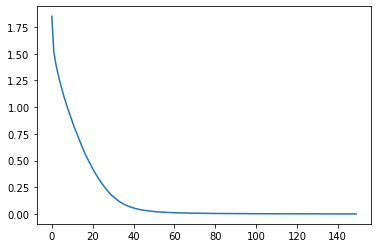

In [11]:
plt.plot(np.arange(len(train_loss_plt)),train_loss_plt)

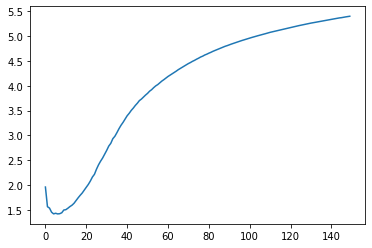

In [12]:
plt.plot(np.arange(len(test_loss_plt)),test_loss_plt)

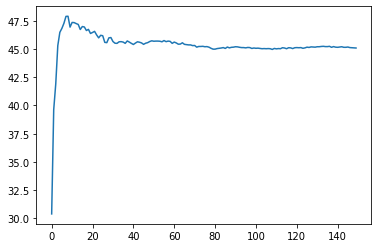

In [13]:
plt.plot(np.arange(len(test_accuracy_plt)),test_accuracy_plt)

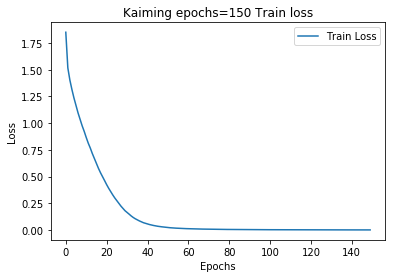

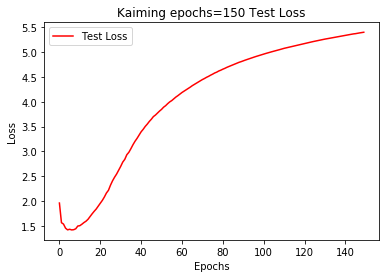

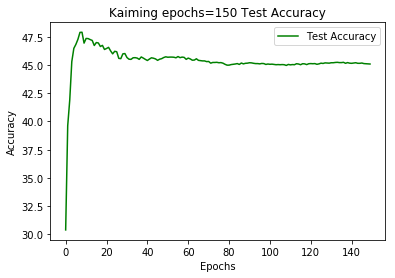

In [2]:
import joblib
import matplotlib.pyplot as plt
import numpy as np

train_loss_plt = joblib.load('train_loss_plt_q3_Kaiming_150.sav')
test_loss_plt = joblib.load('test_loss_plt_q3_Kaiming_150.sav')
test_accuracy_plt = joblib.load('test_accuracy_plt_q3_Kaiming_150.sav')

plt.title('Kaiming epochs=150 Train loss')
plt.plot(np.arange(len(train_loss_plt)),train_loss_plt,label = 'Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.title('Kaiming epochs=150 Test Loss')
plt.plot(np.arange(len(test_loss_plt)),test_loss_plt,color='r',label = 'Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.title('Kaiming epochs=150 Test Accuracy')
plt.plot(np.arange(len(test_accuracy_plt)),test_accuracy_plt,color='g',label = 'Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()